Setup and data
-----

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

az.style.use('arviz-darkgrid')

In [2]:
data = pd.read_csv("../DataSets/wdi_wide.csv")
data = data[["Life expectancy, female", "GNI", "Internet use", "International tourism", "Physicians"]]
data = data.dropna()

Extract and normalize data:

In [3]:
Life = data["Life expectancy, female"]
Life = (Life - Life.mean())/Life.std()

GNI = data["GNI"]
GNI = (GNI - GNI.mean())/GNI.std()

Internet = data["Internet use"]
Internet = (Internet - Internet.mean())/Internet.std()

Tourism = data["International tourism"]
Tourism = (Tourism - Tourism.mean())/Tourism.std()

Physicians = data["Physicians"]
Physicians = (Physicians - Physicians.mean())/Physicians.std()

In [4]:
data["Life expectancy, female"].std()

7.504672587459998

Model
-----

This dataset contains the life expectancies for females for different countries, various factors are also in the dataset. Countries with missing values are omitted for simplicity. 
Here, it is more interesting to accertain which factors contribute to female life expectancy (and whether positively or negatively), so Bayessian Feature Importance will be used, that is, the regression function is

$\alpha(X) = w_0 + \sum_i \delta_i w_i X_i$ with $\delta_i \in \{0, 1\}$ being indicators of whether or not a factor should be included.

The target value, life expectancy, is essentially a sum of ages of death of female citizens divided by their number, and so by the central limit theorem it could be argued that a normal distribution for the noize would make sense, even though life expextancy can't take on negative values, for example. And so, we assume the model $t_i | W, \Delta, \sigma \sim N(\alpha(X_i), \sigma^2)$.

Now, to describe prior distributions. Obviously, $\delta_i \sim Ber(0.5)$.

$\sigma^2$ describes, essentially,the variance in life expectancy in different countries with similar environments. It doesn't make sense for it to be arbitrarily large, because life expectancy as a value is bounded, as people ususally don't live, say, 140 years. However, it can not be said whether $\sigma$ should be big or small, and therefore a uniform distribution will be employed: $\sigma \sim U(0, 140 / 7.5)$, where we take into account the normalization that took place.

For the coefficients, let us employ normal distributions with big standard variations.

All of that results in the following model:

$t_i | W, \Delta, \sigma \sim N(\alpha(X_i), \sigma^2)$ 

$\delta_i \sim Ber(0.5)$

$\sigma^2 \sim U(0, 19)$

$w_i \sim N(0, 10)$


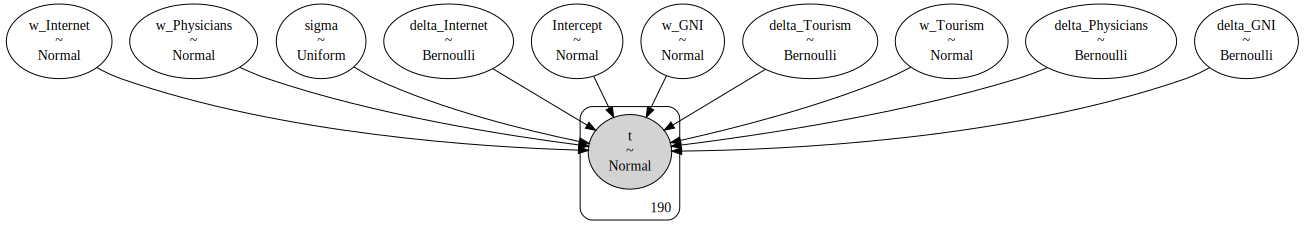

In [72]:
with pm.Model() as model:    
    
    delta_GNI = pm.Bernoulli('delta_GNI', p = 0.5)
    delta_Internet = pm.Bernoulli('delta_Internet', p = 0.5)
    delta_Tourism = pm.Bernoulli('delta_Tourism', p = 0.5)
    delta_Physicians = pm.Bernoulli('delta_Physicians', p = 0.5)
    
    
    Intercept = pm.Normal('Intercept', mu=0, sigma=1)
    w_GNI = pm.Normal('w_GNI', mu=0, sigma=1)
    w_Internet = pm.Normal('w_Internet', mu=0, sigma=1)
    w_Tourism = pm.Normal('w_Tourism', mu=0, sigma=1)
    w_Physicians = pm.Normal('w_Physicians', mu=0, sigma=1)
    
   
    
    sigma = pm.Uniform('sigma', lower = 0, upper = 19)
    
    alpha = Intercept + \
            delta_GNI * w_GNI * GNI + \
            delta_Internet * w_Internet * Internet + \
            delta_Tourism * w_Tourism * Tourism + \
            delta_Physicians * w_Physicians * Physicians
    
    output = pm.Normal('t', mu= alpha, sigma = sigma, observed=Life)
    
pm.model_to_graphviz(model)

Sampling
-------

In [74]:
with model:
    trace = pm.sample(20000, tune=20000, chains=4, cores=4,
                     return_inferencedata=True, target_accept=0.99) #Set target_accept to mitigate divergencies

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [delta_GNI, delta_Internet, delta_Tourism, delta_Physicians]
>NUTS: [Intercept, w_GNI, w_Internet, w_Tourism, w_Physicians, sigma]


Sampling 4 chains for 20_000 tune and 20_000 draw iterations (80_000 + 80_000 draws total) took 801 seconds.
/home/bunta1/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


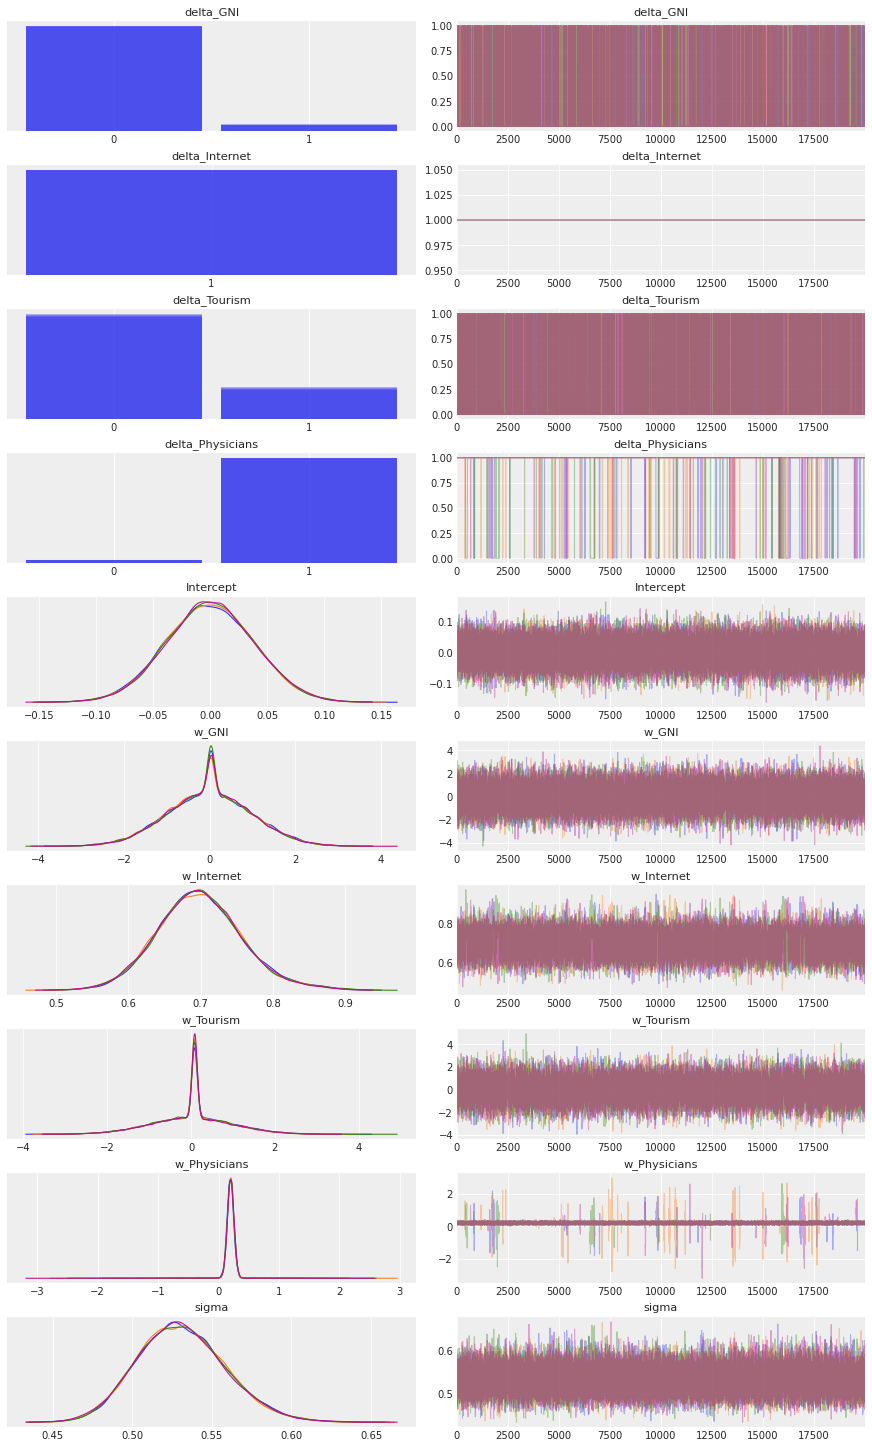

In [75]:
az.plot_trace(trace, compact=False);

It seems to be the case that we can be confident that GNI is not required in the model, as the posterior distribution for $\delta_{GNI}$ suggests. We shall fit a model without it later, but now let us focus on whether or not the marcov chains have reached their stationary distributions.

Looking at the graphs it seems that the two chains have mixed quite nicely, the plots of posterior densities also coincide, which suggests that the chains did reach their stationary distributions.

Let us examine some statistics.

In [76]:
az.ess(trace, var_names = ["delta_GNI", "delta_Internet", "delta_Tourism", "delta_Physicians"])

<xarray.Dataset>
Dimensions:           ()
Data variables:
    delta_GNI         float64 3.619e+04
    delta_Internet    float64 8e+04
    delta_Tourism     float64 9.684e+03
    delta_Physicians  float64 1.062e+03

These are the effective sample sizes. Overall there were 4 $\times 10^{4}$ samples, so it would be nice to see numbers close to that. For $\delta_{Physicians}$ and $\delta_{Tourism}$ the effective sample size is comparatively small, however, considering that it is a bernoulli random variable and that a 99.9%-CI for its parameter with the given effective sample size would have width not exceeding $\frac{1}{n_{effective}}$, it is good enough for our purposes. Other effective sample sizes are great.

In [77]:
az.ess(trace, var_names = ["w_GNI", "w_Internet", "w_Tourism", "w_Physicians", "sigma"])

<xarray.Dataset>
Dimensions:       ()
Data variables:
    w_GNI         float64 5.713e+04
    w_Internet    float64 7.129e+03
    w_Tourism     float64 4.994e+04
    w_Physicians  float64 2.775e+04
    sigma         float64 5.409e+04

Here $w_{Internet}$ is the obvious outlier, having the effective sample size be just eightht of the actual sample size. The rest are fine.

In [78]:
az.summary(trace)

/home/bunta1/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta_GNI,0.060,0.238,0.000,1.000,0.001,0.001,36185.0,36185.0,1.0
delta_Internet,1.000,0.000,1.000,1.000,0.000,0.000,80000.0,80000.0,NaN
delta_Tourism,0.229,0.420,0.000,1.000,0.004,0.003,9684.0,9684.0,1.0
delta_Physicians,0.968,0.175,1.000,1.000,0.005,0.004,1062.0,80000.0,1.0
Intercept,-0.000,0.039,-0.073,0.072,0.000,0.000,64683.0,51164.0,1.0
w_GNI,-0.001,0.973,-1.822,1.892,0.004,0.004,57132.0,49154.0,1.0
w_Internet,0.699,0.060,0.583,0.809,0.001,0.001,7129.0,2971.0,1.0
w_Tourism,0.022,0.886,-1.741,1.813,0.004,0.004,49937.0,44791.0,1.0
w_Physicians,0.192,0.182,0.082,0.315,0.002,0.003,27753.0,6599.0,1.0
sigma,0.531,0.028,0.479,0.583,0.000,0.000,54087.0,45543.0,1.0


Looking at the shrink factors, we see that they are all very close to 1, which suggests that the chains did reach the stationary distribution. For $\delta_{Internet}$ the value is NaN, however that is due to the fact that its posterior distribution is determenistic and thus has variance zero.

Overall it is safe to conclude that all the chains have reached their stationary distributions.

Removing factors
------------

It was estimated that the posterior probabilities of inclusion of the factors GNI and Tourism are 6% and 23% respectively. Let us fit a model without these two factors.

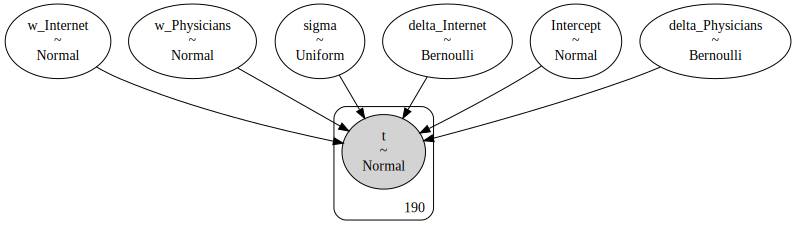

In [79]:
with pm.Model() as model_2:    
    
    delta_Internet = pm.Bernoulli('delta_Internet', p = 0.5)
    delta_Physicians = pm.Bernoulli('delta_Physicians', p = 0.5)
    
    
    Intercept = pm.Normal('Intercept', mu=0, sigma=1)
    w_Internet = pm.Normal('w_Internet', mu=0, sigma=1)
    w_Physicians = pm.Normal('w_Physicians', mu=0, sigma=1)
    
   
    
    sigma = pm.Uniform('sigma', lower = 0, upper = 19)
    
    alpha = Intercept + \
            delta_Internet * w_Internet * Internet + \
            delta_Physicians * w_Physicians * Physicians
    
    output = pm.Normal('t', mu= alpha, sigma = sigma, observed=Life)
    
pm.model_to_graphviz(model_2)

In [81]:
with model_2:
    trace_2 = pm.sample(20000, tune=20000, chains=4, cores=4,
                     return_inferencedata=True, target_accept=0.99)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [delta_Internet, delta_Physicians]
>NUTS: [Intercept, w_Internet, w_Physicians, sigma]


Sampling 4 chains for 20_000 tune and 20_000 draw iterations (80_000 + 80_000 draws total) took 196 seconds.
/home/bunta1/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


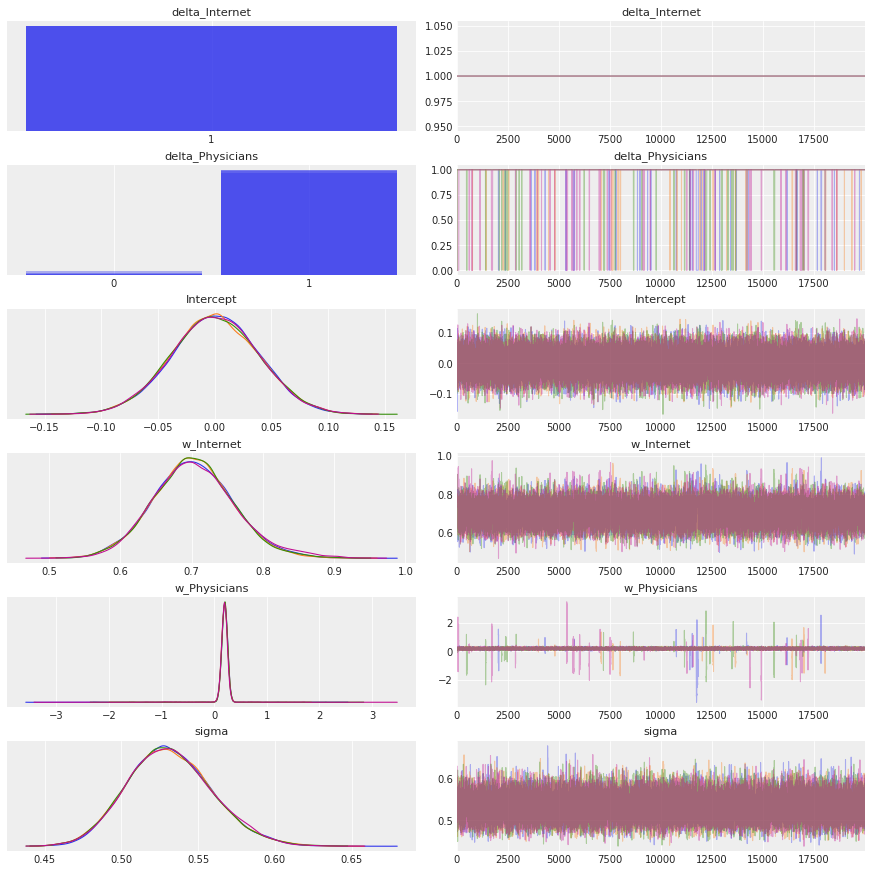

In [82]:
az.plot_trace(trace_2, compact=False);

In [83]:
az.summary(trace_2)

/home/bunta1/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta_Internet,1.000,0.000,1.000,1.000,0.000,0.000,80000.0,80000.0,NaN
delta_Physicians,0.979,0.142,1.000,1.000,0.003,0.002,1970.0,80000.0,1.0
Intercept,0.000,0.039,-0.073,0.072,0.000,0.000,49680.0,45789.0,1.0
w_Internet,0.703,0.057,0.593,0.811,0.001,0.000,13104.0,5882.0,1.0
w_Physicians,0.190,0.171,0.086,0.305,0.002,0.003,26055.0,9668.0,1.0
sigma,0.532,0.028,0.480,0.584,0.000,0.000,44907.0,47418.0,1.0


The result is similar, though this time we are more confident in the inclusion of Physicians. The shrink factors and graphs indicate that the chains reached their stationary distributions.

One factor choice
------

To choose the most important factor of the four we could just choose the one with the biggest posterior probability, however, since we only have two factors left, we could employ an indicator of the Internet factor being used instead of the Physicians factor, leading to a more sound answer.

The model then will be as follows:

$\beta(X) = \delta w_1 X_1 + (1 - \delta)w_2 X_2$

$t_i | W, \Delta, \sigma \sim N(\beta(X_i), \sigma^2)$ 

$\delta \sim Ber(0.5)$

$\sigma^2 \sim U(0, 19)$

$w_i \sim N(0, 10)$

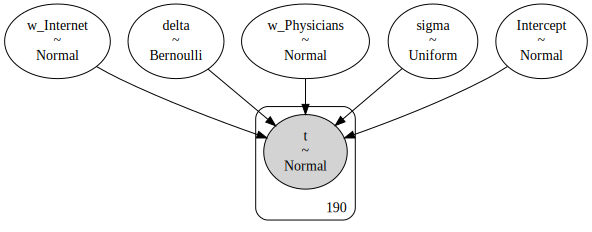

In [98]:
with pm.Model() as model_3:    
    

    delta = pm.Bernoulli('delta', p = 0.5)
    
    
    Intercept = pm.Normal('Intercept', mu=0, sigma=1)
    w_Internet = pm.Normal('w_Internet', mu=0, sigma=1)
    w_Physicians = pm.Normal('w_Physicians', mu=0, sigma=1)
    
   
    
    sigma = pm.Uniform('sigma', lower = 0, upper = 19)
    
    alpha = Intercept + \
            delta * w_Internet * Internet + \
            (1 - delta) * w_Physicians * Physicians
    
    output = pm.Normal('t', mu= alpha, sigma = sigma, observed=Life)
    
pm.model_to_graphviz(model_3)

In [99]:
with model_3:
    trace_3 = pm.sample(20000, tune=20000, chains=4, cores=4,
                     return_inferencedata=True, target_accept=0.99)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [delta]
>NUTS: [Intercept, w_Internet, w_Physicians, sigma]


Sampling 4 chains for 20_000 tune and 20_000 draw iterations (80_000 + 80_000 draws total) took 105 seconds.
/home/bunta1/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


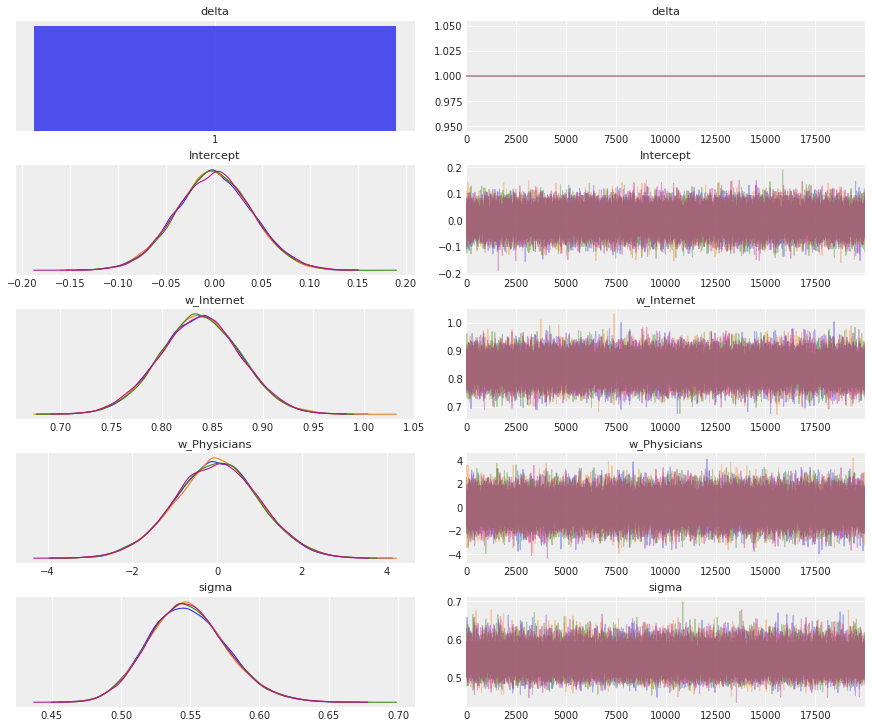

In [100]:
az.plot_trace(trace_3, compact=False);

In [101]:
az.summary(trace_3)

/home/bunta1/.local/lib/python3.10/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
delta,1.000,0.000,1.000,1.000,0.000,0.000,80000.0,80000.0,NaN
Intercept,0.000,0.040,-0.074,0.076,0.000,0.000,65050.0,51203.0,1.0
w_Internet,0.838,0.040,0.761,0.912,0.000,0.000,78154.0,53230.0,1.0
w_Physicians,-0.002,1.013,-1.920,1.918,0.004,0.004,80110.0,54201.0,1.0
sigma,0.548,0.028,0.495,0.601,0.000,0.000,80428.0,51707.0,1.0


Again, it seems that the MCMC algorithm was successful and that the Internet factor is the factor that should be left in the model. Now, let us fit one last model with that in mind.

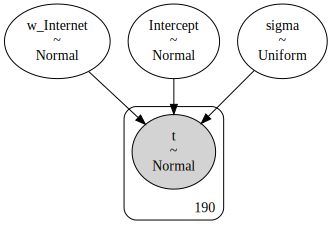

In [109]:
with pm.Model() as model_4:    
    
    
    
    Intercept = pm.Normal('Intercept', mu=0, sigma=1)
    w_Internet = pm.Normal('w_Internet', mu=0, sigma=1)  
   
    
    sigma = pm.Uniform('sigma', lower = 0, upper = 19)
    
    alpha = Intercept + \
            w_Internet * Internet
    
    output = pm.Normal('t', mu= alpha, sigma = sigma, observed=Life)
    
pm.model_to_graphviz(model_4)

In [110]:
with model_4:
    trace_4 = pm.sample(20000, tune=20000, chains=4, cores=4,
                     return_inferencedata=True, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, w_Internet, sigma]


Sampling 4 chains for 20_000 tune and 20_000 draw iterations (80_000 + 80_000 draws total) took 78 seconds.


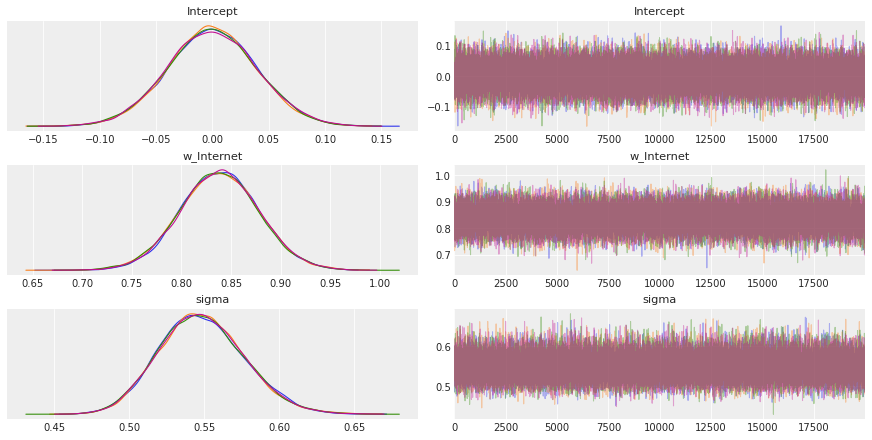

In [111]:
az.plot_trace(trace_4, compact=False);

In [112]:
az.summary(trace_4)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.000,0.040,-0.076,0.074,0.0,0.0,61639.0,49296.0,1.0
w_Internet,0.838,0.040,0.762,0.913,0.0,0.0,57648.0,48480.0,1.0
sigma,0.549,0.028,0.495,0.601,0.0,0.0,57754.0,49370.0,1.0


Non-Bayessian approach
------------

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance

In [123]:
X = np.array([GNI, Internet, Tourism, Physicians]).T
names = ["GNI", "Internet", "Tourism", "Physicians"]
reg = LinearRegression().fit(X, Life)

print(reg.coef_)
print(reg.intercept_)
print(reg.score(np.array([GNI, Internet, Tourism, Physicians]).T, Life))

[-0.01897238  0.68049857  0.09371858  0.1898646 ]
-1.2387065803969424e-15
0.7304483375732301


In [141]:
np.mean((reg.predict(X) - Life)**2)

0.26813296946662896

Here we will be using a technique called permutation importance, that is, we shuffle the values of the factor, the importance of which we wish to measure, and look at the change in the $R^2$ statistic.

r = permutation_importance(reg, X, Life)
for i in r.importances_mean.argsort()[::-1]:
        print(f"{names[i]}  "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

Looking at the posterior probabilities of inclusion in our first bayessian model, we see that the order of importance obtained here is the same as in the BFI.

The fitted coefficients are also very similar to those obtained with the bayessian approach, that is, to the MAP estimations.
Estimated standard arror, however, is much smaller here. this could be due to a lack of a testing set, however, there is not much data to go around as is, so splitting it would not be ideal.

Additionally, the bayessian approach resulted in estimations of how confident we are that a feature shoould be used in the model, permutation importance can not be interpreted in as much a convenient way.